# Project 05-2: Predicting Housing Prices in Cook County

## Introduction

In Project 05-1, I performed some basic Exploratory Data Analysis (EDA), laying out the thought process that leads to certain modeling decisions. Then, you added a few new features to the dataset and cleaned the data in the process.

In this project, I will specify and fit a linear model to a few features of the housing data to predict house prices. Then, we will analyze the error of the model and brainstorm ways to improve the model's performance. Finally, I'll delve deeper into the implications of predictive modeling within the Cook County Assessor's Office (CCAO) case study. This is especially relevant because statistical modeling is how the CCAO valuates properties. 

Given the history of racial discrimination in housing policy and property taxation in Cook County, consider the impacts of my modeling results as I work through this project, and think about what fairness might mean to property owners in Cook County.

In [2]:
import numpy as np

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

from ds100_utils import *
from feature_func import *

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

Load the training, validation, and test data.

In [6]:
with zipfile.ZipFile('cook_county_data.zip') as item:
    item.extractall()

The dataset is split into a training set, a validation set, and a test set. In this project, I will train and validate a model using the training and validation sets, and then use a model trained on the combined training and validation sets to predict the `Sale Price`s of the test set. 

- Importantly, the test set I used does not contain the values of our target variable, `Sale Price`. I can only use this test set to generate predictions.

In the cell below, I load the training and validation sets into the `DataFrame` `training_val_data` and the test set into the `DataFrame` `test_data`.

In [7]:
training_val_data = pd.read_csv("cook_county_train_val.csv", index_col='Unnamed: 0')
test_data = pd.read_csv("cook_county_contest_test.csv", index_col='Unnamed: 0')

FileNotFoundError: [Errno 2] No such file or directory: 'cook_county_train_val.csv'

As a good sanity check, we should at least verify that the shape of the data matches the description.

In [8]:
# 204792 observations and 62 features in training data
assert training_val_data.shape == (204792, 62)

# 55311 observations and 61 features in test data
assert test_data.shape == (55311, 61)

# Sale Price is provided in the training/validation data
assert 'Sale Price' in training_val_data.columns.values

# Sale Price is hidden in the test data
assert 'Sale Price' not in test_data.columns.values

Next, I will print the columns in the dataset. 

In [9]:
training_val_data.columns.values

array(['PIN', 'Property Class', 'Neighborhood Code', 'Land Square Feet',
       'Town Code', 'Apartments', 'Wall Material', 'Roof Material',
       'Basement', 'Basement Finish', 'Central Heating', 'Other Heating',
       'Central Air', 'Fireplaces', 'Attic Type', 'Attic Finish',
       'Design Plan', 'Cathedral Ceiling', 'Construction Quality',
       'Site Desirability', 'Garage 1 Size', 'Garage 1 Material',
       'Garage 1 Attachment', 'Garage 1 Area', 'Garage 2 Size',
       'Garage 2 Material', 'Garage 2 Attachment', 'Garage 2 Area',
       'Porch', 'Other Improvements', 'Building Square Feet',
       'Repair Condition', 'Multi Code', 'Number of Commercial Units',
       'Estimate (Land)', 'Estimate (Building)', 'Deed No.', 'Sale Price',
       'Longitude', 'Latitude', 'Census Tract',
       'Multi Property Indicator', 'Modeling Group', 'Age', 'Use',
       "O'Hare Noise", 'Floodplain', 'Road Proximity', 'Sale Year',
       'Sale Quarter', 'Sale Half-Year', 'Sale Quarter of Year'

<!-- BEGIN QUESTION -->

<br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

## 👥 Question 1: Human Context and Ethics

In this part of the project, I will explore the human context of our housing dataset.

<br>

--- 

### Part 1-1
Consider the following question: *"How much is a house worth?"*

Who might be interested in an answer to this question? Be sure to list at least three different parties (people or organizations) and state whether each one has an interest in seeing a low or high housing price.

Homebuyers might be interested in finding a house at a price that fits their budget. Real Estate Developers might be interested in high housing prices because they seek to maximize their profits from property sales. Local governments might be interested because they are interested in housing prices to gauge the economic health of an area.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br>

--- 

### Part 1-2

Which of the following scenarios strikes you as unfair, and why? You can choose more than one. There is no single right answer, but you must explain your reasoning. Would you consider some of these scenarios more (or less) fair than others? Why?

A. A homeowner whose home is assessed at a higher price than it would sell for.  

B. A homeowner whose home is assessed at a lower price than it would sell for. 

C. An assessment process that systematically overvalues inexpensive properties and undervalues expensive properties.  

D. An assessment process that systematically undervalues inexpensive properties and overvalues expensive properties.

C is unfair because it can unjust tax burden on low-income homeowners and wealthier homeowners would benefit from undervalued assessments. D is also unfair because it places a heavier tax burden on low-income homeowners with inexpensive properties.

## The CCAO Dataset

I'll work with the dataset from the Cook County Assessor's Office (CCAO) in Illinois. This government institution determines property taxes across most of Chicago's metropolitan areas and nearby suburbs. In the United States, all property owners must pay property taxes, which are then used to fund public services, including education, road maintenance, and sanitation. These property tax assessments are based on property values estimated using statistical models considering multiple factors, such as real estate value and construction cost.

However, this system is not without flaws. In late 2017, a lawsuit was filed against the office of Cook County Assessor Joseph Berrios for producing "[racially discriminatory assessments and taxes](https://www.chicagotribune.com/politics/ct-cook-county-board-assessor-berrios-met-20170718-story.html)." The lawsuit included claims that the assessor's office undervalued high-priced homes and overvalued low-priced homes, creating a visible divide along racial lines. Wealthy homeowners, who were typically white, paid less in property taxes, whereas [working-class, non-white homeowners paid more](https://www.chicagotribune.com/news/breaking/ct-cook-county-assessor-berrios-sued-met-20171214-story.html).

The Chicago Tribune's four-part series, "[The Tax Divide](https://www.chicagotribune.com/investigations/ct-tax-divide-investigation-20180425-storygallery.html)," delves into how this was uncovered. After "compiling and analyzing more than 100 million property tax records from the years 2003 through 2015, along with thousands of pages of documents, then vetting the findings with top experts in the field," they discovered that "residential assessments had been so far off the mark for so many years." You can read more about their investigation [here](https://apps.chicagotribune.com/news/watchdog/cook-county-property-tax-divide/assessments.html).

<!-- BEGIN QUESTION -->

<br>

--- 

### Part 1-3

What were the central problems with the earlier property tax system in Cook County as reported by the Chicago Tribune? What were the primary causes of these problems?

The system disproportionately overvalued low-priced homes and undervalued high-priced homes. The primary causes were flaws in the statistical models used by the assessor's office, which led to inaccurate assessments.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br>

--- 

### Part 1-4

In addition to being regressive, how did the property tax system in Cook County place a disproportionate tax burden on non-white property owners?

The property tax system in Cook County placed a disproportionate tax burden on non-white property owners because the system systematically undervalued properties in predominantly non-white neighborhoods. Therefore, these homeowners had higher property taxes compared to the value of their homes compared to wealthier neighborhoods where properties were undervalued. The statistical models used by the assessor’s office did not account for the racial disparities in property assessments, leading to higher tax burdens on non-white homeowners, particularly in lower-income areas.

<!-- END QUESTION -->

<br>

<hr style="border: 1px solid #fdb515;" />

## Section 2: Preparing Data


I will next split the dataset into a training set and a validation set. I will use the training set to fit our model's parameters and the validation set to evaluate how well our model will perform on unseen data drawn from the same distribution as the training set. 

> If I used all the data to fit our model, I would not have a way to estimate model performance on **unseen data** such as the test set in `cook_county_contest_test.csv`.

In the cell below, complete the function `train_val_split` that splits `data` into two smaller `DataFrame`s named `train` and `validation`. Let `train` contain 80% of the data, and let `validation` contain the remaining 20%.

To ensure that my code matches the solution, I will use the first 80% as the training set and the last 20% as the validation set.

In [12]:
# This makes the train-validation split in this section reproducible across different runs 
# of the notebook. You do not need this line to run train_val_split in general.

# DO NOT CHANGE THIS LINE
np.random.seed(1337)
# DO NOT CHANGE THIS LINE

def train_val_split(data):
    """ 
    Takes in a DataFrame `data` and randomly splits it into two smaller DataFrames 
    named `train` and `validation` with 80% and 20% of the data, respectively. 
    """
    
    data_len = data.shape[0]
    shuffled_indices = np.random.permutation(data_len)
    train_indices = shuffled_indices[:int(0.8 * data_len)]
    validation_indices = shuffled_indices[int(0.8 * data_len):]
    train = data.iloc[train_indices]
    validation = data.iloc[validation_indices]
   
    return train, validation
train, validation = train_val_split(training_val_data)

<br>

<hr style="border: 1px solid #fdb515;" />

## Section 3: Fitting a Simple Model

I'll fit a linear regression model using the ordinary least squares (OLS) estimator. I will start with a simple model that uses only two features: the **number of bathrooms** in the household and the **log-transformed total area covered by the building** (in square feet). 

Consider the following expression for my first linear model that contains one of the features:

$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bathrooms})
$$

In parallel, I will also consider a second model that contains both features:

$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bathrooms}) + \theta_2 \cdot (\text{Log Building Square Feet})
$$

<br>

### Pipeline Function

In Project 05-1, I wrote a few functions that added features to the dataset. Instead of calling them manually one by one, it is best practice to encapsulate all of this feature engineering into one "pipeline" function. Pipelines reduce all the feature engineering to just one function call and ensures that the same transformations are applied to all data.  

In [16]:
from feature_func import *    # Import functions from Project A1

###### Copy any function you would like to below ######
...
#######################################################


def feature_engine_simple(data):
    # Remove outliers
    data = remove_outliers(data, 'Sale Price', lower=499)
    # Create Log Sale Price column
    data = log_transform(data, 'Sale Price')
    # Create Bathrooms column
    data = add_total_bathrooms (data)
    # Select X and Y from the full data
    X = data[['Bathrooms']]
    Y = data['Log Sale Price']
    return X, Y

# Reload the data
full_data = pd.read_csv("cook_county_train.csv")

# Process the data using the pipeline for the first model.
np.random.seed(1337)
train_m1, valid_m1 = train_val_split(full_data)
X_train_m1_simple, Y_train_m1_simple = feature_engine_simple(train_m1)
X_valid_m1_simple, Y_valid_m1_simple = feature_engine_simple(valid_m1)

# Take a look at the result
display(X_train_m1_simple.head())
display(Y_train_m1_simple.head())

,Bathrooms
130829,2.5
193890,1.0
30507,1.5
91308,1.5
131132,2.5


130829    12.994530
193890    11.848683
30507     11.813030
91308     13.060488
131132    12.516861
Name: Log Sale Price, dtype: float64

### `.pipe`

Alternatively, I can build the pipeline using `pd.DataFrame.pipe` ([documentation](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pipe.html)). Take a look at the use of `pd.DataFrame.pipe` below. 

The following function `feature_engine_pipe` takes in a `DataFrame` `data`, a list `pipeline_functions` containing 3-element tuples `(function, arguments, keyword_arguments)` that will be called on `data` in the pipeline, and the label `prediction_col` that represents the column of our target variable (`Sale Price` in this case). You can use this function with each of the tuples passed in through `pipeline_functions`.

In [17]:
# Run this cell to define feature_engine_pipe; no further action is needed.
def feature_engine_pipe(data, pipeline_functions, prediction_col):
    """Process the data for a guided model."""
    for function, arguments, keyword_arguments in pipeline_functions:
        if keyword_arguments and (not arguments):
            data = data.pipe(function, **keyword_arguments)
        elif (not keyword_arguments) and (arguments):
            data = data.pipe(function, *arguments)
        else:
            data = data.pipe(function)
    X = data.drop(columns=[prediction_col])
    Y = data.loc[:, prediction_col]
    return X, Y

<br>

--- 

## Part 3-2

It is time to prepare the training and validation data for the two models I proposed above. Use the following two cells to reload a fresh dataset and run it through the following preprocessing steps using `feature_engine_pipe`. **You will run the steps below two times: once for the first model, and once for the second model.**

- Perform a `train_val_split` on the original dataset, loaded as the `DataFrame` `full_data`. Let 80% of the set be training data, and 20% of the set be validation data. This split should be identical for both models. 
- For both the training and validation set,
    1. Remove outliers in `Sale Price`. We only consider households with a price that is greater than 499 dollars (or equivalently, a price that is 500 dollars or greater). 
    2. Apply log transformations to the `Sale Price` and the `Building Square Feet` columns to create two new columns, `Log Sale Price` and `Log Building Square Feet`.
    3. Extract the total number of Bathrooms into a new column `Bathrooms` from the `Description` column.
    4. Select the columns `Log Sale Price` and `Bathrooms` (and `Log Building Square Feet` if this is the second model). We have implemented the helper function `select_columns` for you.
    5. Return the design matrix $\mathbb{X}$ and the observed vector $\mathbb{Y}$. Note that $\mathbb{Y}$ refers to the transformed `Log Sale Price`, not the original `Sale Price`. **Your design matrix and observed vector should be `NumPy` arrays or `pandas` `DataFrame`s**.

Assign the final training data and validation data for both models to the following set of variables:

- First Model: `X_train_m1`, `Y_train_m1`, `X_valid_m1`, `Y_valid_m1`. This is already implemented for you. 
- Second Model: `X_train_m2`, `Y_train_m2`, `X_valid_m2`, `Y_valid_m2`. Please implement this in the second cell below. You may use the first model as an example.

As an example of how to work with pipelines, we have processed model 1 for you using `m1_pipelines` by passing in the corresponding pipeline functions as a list of tuples. Your task is to do the same thing for model 2. In other words, save the relevant pipeline functions for model 2 as a list of tuples and assign it to `m2_pipelines`.

As a refresher, the equations of model 1 and model 2, respectively, are:
$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bathrooms})
$$


$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bathrooms}) + \theta_2 \cdot (\text{Log Building Square Feet})
$$

**Note**: Do not change the line `np.random.seed(1337)` as it ensures we are partitioning the dataset the same way for both models (otherwise, their performance isn't directly comparable).

In [18]:
# Reload the data
full_data = pd.read_csv("cook_county_train.csv")

# Apply feature engineering to the data using the pipeline for the first model
np.random.seed(1337)
train_m1, valid_m1 = train_val_split(full_data)

# Helper function
def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

# Pipelines, a list of tuples
m1_pipelines = [
    (remove_outliers, None, {
        'variable': 'Sale Price',
        'lower': 499,
    }),
    (log_transform, None, {'col': 'Sale Price'}),
    (add_total_bathrooms, None, None),
    (select_columns, ['Log Sale Price', 'Bathrooms'], None)
]

X_train_m1, Y_train_m1 = feature_engine_pipe(train_m1, m1_pipelines, 'Log Sale Price')
X_valid_m1, Y_valid_m1 = feature_engine_pipe(valid_m1, m1_pipelines, 'Log Sale Price')

# Take a look at the result
# It should be the same above as the result returned by feature_engine_simple
display(X_train_m1.head())
display(Y_train_m1.head())

,Bathrooms
130829,2.5
193890,1.0
30507,1.5
91308,1.5
131132,2.5


130829    12.994530
193890    11.848683
30507     11.813030
91308     13.060488
131132    12.516861
Name: Log Sale Price, dtype: float64

In [19]:
# DO NOT CHANGE THIS LINE
np.random.seed(1337)
# DO NOT CHANGE THIS LINE

# Process the data using the pipeline for the second model
train_m2, valid_m2 = train_val_split(full_data)

m2_pipelines = [
    (remove_outliers, None, {
        'variable': 'Sale Price',
        'lower': 499,
    }),
    (log_transform, None, {'col': 'Sale Price'}),
    (add_total_bathrooms, None, None),
    (log_transform, ['Building Square Feet'], None),  # log-transform for Building Square Feet
    (select_columns, ['Log Sale Price', 'Bathrooms', 'Log Building Square Feet'], None)  # Select columns for the second model
]

X_train_m2, Y_train_m2 = feature_engine_pipe(train_m2, m2_pipelines, 'Log Sale Price')
X_valid_m2, Y_valid_m2 = feature_engine_pipe(valid_m2, m2_pipelines, 'Log Sale Price')


# Take a look at the result
display(X_train_m2.head())
display(Y_train_m2.head())

,Bathrooms,Log Building Square Feet
130829,2.5,7.870166
193890,1.0,7.002156
30507,1.5,6.851185
91308,1.5,7.228388
131132,2.5,7.990915


130829    12.994530
193890    11.848683
30507     11.813030
91308     13.060488
131132    12.516861
Name: Log Sale Price, dtype: float64

<br>

--- 

## Part 3-3

Finally, I'll do some regression!

I will first initialize a `sklearn.linear_model.LinearRegression` object [(documentation)](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) for both of our models. We set the `fit_intercept = True` to ensure that the linear model has a non-zero intercept (i.e., a bias term).

In [21]:
linear_model_m1 = lm.LinearRegression(fit_intercept=True)
linear_model_m2 = lm.LinearRegression(fit_intercept=True)

Now it's time to fit my linear regression model. Use the cell below to fit both models. Then, use the fitted models to compute the predicted values of `Log Sale Price` for the training data and the predicted values of `Log Sale Price` for the validation data.

Assign the predicted values from both of your models on the training and validation set to the following variables:

- For the first Model, assign the predicted values for the **training set** to `Y_fitted_m1`, and predicted values for the **validation set** to `Y_predicted_m1`.
- For the second model, assign the predicted values for the **training set** to `Y_fitted_m2`, and the predicted values for the **validation set** to `Y_predicted_m2`.

In [22]:
# Fit the 1st model
linear_model_m1.fit(X_train_m1, Y_train_m1)

# Compute the fitted and predicted values of Log Sale Price for 1st model
Y_fitted_m1 = linear_model_m1.predict(X_train_m1)
Y_predicted_m1 = linear_model_m1.predict(X_valid_m1)

# Fit the 2nd model
linear_model_m2.fit(X_train_m2, Y_train_m2)
# Compute the fitted and predicted values of Log Sale Price for 2nd model
Y_fitted_m2 = linear_model_m2.predict(X_train_m2)
Y_predicted_m2 = linear_model_m2.predict(X_valid_m2)

<br>

<hr style="border: 1px solid #fdb515;" />

## Section 4: Evaluate Our Simple Model

<br>

--- 

Let's now move into the analysis of my two models!

In [24]:
def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values.
    Input:
      predicted (1D array): Vector of predicted/fitted values
      actual (1D array): Vector of actual values
    Output:
      A float, the RMSE value.
    """
    return np.sqrt(np.mean((actual - predicted)**2))

<!-- BEGIN QUESTION -->

<br>

--- 

## Part 1

I can assess a model's performance and quality of fit with a plot of the residuals ($y-\hat{y}$) versus the observed outcomes ($y$).

In the cell below, use `plt.scatter` [(documentation)](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) to plot the **model 2** residuals of `Log Sale Price` versus the original `Log Sale Price` values. For this part, you only need to plot the residuals and outcomes for the **validation data**.

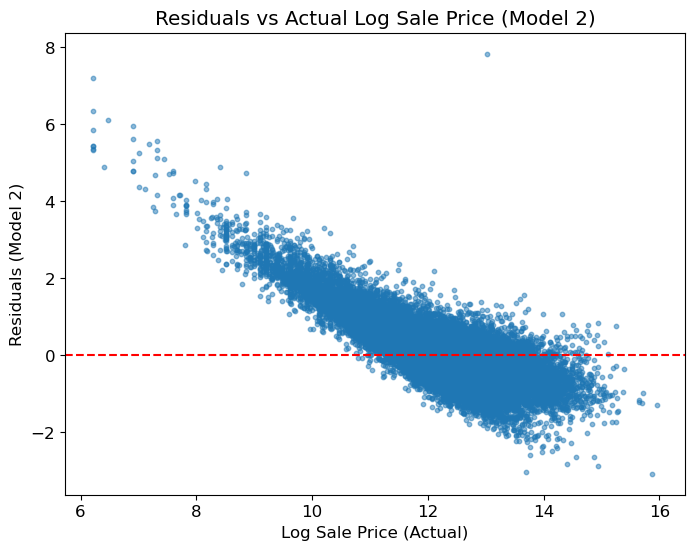

In [25]:
residuals_m2 = Y_predicted_m2 - Y_valid_m2

plt.figure(figsize=(8, 6))
plt.scatter(Y_valid_m2, residuals_m2, alpha=0.5, s=10)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Log Sale Price (Actual)')
plt.ylabel('Residuals (Model 2)')
plt.title('Residuals vs Actual Log Sale Price (Model 2)')
plt.show()

<!-- END QUESTION -->

<br>

--- 

## Part 4-2

Based on the structure I see in my plot, does this model appear to correspond to _regressive_, _fair_, or _progressive_ taxation?


In [26]:
"regressive"

<br>

--- 

## Part 2

`k`-fold cross validation (CV) allows us to more accurately evaluate our models than a single train-validation split. In `k`-fold CV, every data point is used in model training at some point. 

> Heads up: I should use `k`-fold cross validation to evaluate the different models you create in Question 5, as you will have limited submissions per day on Gradescope to assess your test RMSE. 

Below, I will implement `compute_CV_error`. `compute_CV_error` should:
1. Use `sklearn`'s `KFold.split` ([documentation](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html))  function to generate `k` splits of the training data. Note that `KFold.split` returns the indices of the data for each split.
2. For **each** split:
    1. Assign the folds to training and validation based on the split indices and desired features.
    2. Train the model on the training folds, and compute the RMSE on the validation fold.
3. Finally, return a **list** of the RMSEs computed for each validation fold. 

In [28]:
from sklearn.model_selection import KFold

def compute_CV_error(X_train, Y_train, folds=10):
    '''
    Split the training data into `k` subsets.
    For each subset, 
        - Fit a model holding out that subset.
        - Compute the MSE on that subset (the validation set).
    You should be fitting `k` models in total.
    Return a list of `k` RMSEs.

    Args:
        model: An sklearn model with fit and predict functions. 
        X_train (DataFrame): Training data.
        Y_train (DataFrame): Label.
    
    Return:
         A list of `k` RMSEs.
    '''
    model = lm.LinearRegression(fit_intercept=True) # Use model that Question 5 requires.
    kf = KFold(n_splits=folds)
    validation_errors = []
    
    for train_idx, valid_idx in kf.split(X_train):
        # Split the data
        split_X_train, split_X_valid = X_train.iloc[train_idx], X_train.iloc[valid_idx]
        split_Y_train, split_Y_valid = Y_train.iloc[train_idx], Y_train.iloc[valid_idx]

        # Fit the model on the training split
        model.fit(split_X_train, split_Y_train)
        
        Y_valid_pred = model.predict(split_X_valid)
        
        # Compute the RMSE on the validation split
        error = np.sqrt(np.mean((split_Y_valid - Y_valid_pred)**2))


        validation_errors.append(error)

    return validation_errors

<br>

--- 

## Part 3

Use `compute_CV_error` to generate two lists of RMSEs generated by 4-fold cross validation: one list for Model 1 and one list for Model 2. Assign these lists to `cv_m1` and `cv_m2`, respectively.

In [30]:
# DO NOT CHANGE THIS LINE
np.random.seed(1337)

# MODIFY THESE LINES
cv_m1 = compute_CV_error(X_train_m1, Y_train_m1, folds=4)
cv_m2 = compute_CV_error(X_train_m2, Y_train_m2, folds=4)
print(f"The RMSE errors for 4-fold cross-validation on Model 1 were: {cv_m1}")
print(f"The RMSE errors for 4-fold cross-validation on Model 2 were: {cv_m2}")

The RMSE errors for 4-fold cross-validation on Model 1 were: [0.8449406074214761, 0.8509652392813478, 0.839719896132506, 0.8390533114490786]
The RMSE errors for 4-fold cross-validation on Model 2 were: [0.7986296447828709, 0.8034792940524004, 0.7947882168346344, 0.7939635404119822]


<br>

<hr style="border: 1px solid #fdb515;" />

# Section 5

It is time to build my own model! Here's what's next:

1. I will conduct feature engineering on your training data using the `feature_engine_final` function (defined in `q5d`), and you will fit and evaluate the model with the training data.
2. I will process the test data with `feature_engine_final`, use the trained model to predict `Log Sale Price` for the test data, transform the predicted and original log-dollar values back to the dollar scale (by using `delog`), and compute the test RMSE.

My goal in Section 5 is to:

* Define a function to perform feature engineering and produce a design matrix for modeling.
* Apply this feature engineering function to the training data and use it to train a model that can predict the `Log Sale Price` of houses.
* Use this trained model to predict the `Log Sale Price`s of the test set. Remember that my test set does not contain the true `Sale Price` of each house –— your model can only predict them! 


Right under the grading scheme, I will outline some important Datahub logistics.

<br>

---

## Part 5-1: Finding Potential Features

Read the documentation about the dataset in `codebook.txt`, located in this directory. Is there any data you think may be related to housing prices? You may want to take note of them below for future reference.

Land Square Feet

<br>

---

## Part 5-2: More EDA

Some potential ideas:
    
* Plot the distribution of a variable. Is this variable heavily skewed? Are there any outliers? This can inform how you engineer your features later on.

* Make a scatter plot between a continuous feature and the outcome. Is there a relationship? Is there a transformation that may linearize the relationship?

* Make a plot of a categorical/discrete feature and the outcome. Is there a relationship? How can we transform this categorical data into numerical features that can be useful for OLS?

* Find the correlation coefficient between features and the outcome. Is there a strong relationship between the two? Can you find the correlation coefficient between different transformations of the feature and the outcome?

</details>

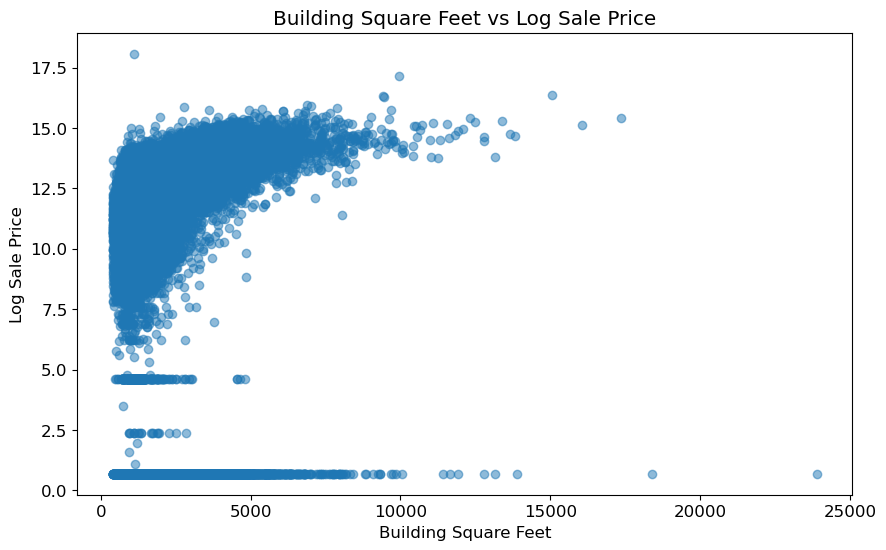

In [33]:
full_data = pd.read_csv('cook_county_train.csv')
if 'Sale Price' in full_data.columns:
    full_data['Log Sale Price'] = np.log1p(full_data['Sale Price'])
else:
    print("Sale Price column not found.")

# Scatter plot: Building Square Feet vs Log Sale Price
plt.figure(figsize=(10, 6))
plt.scatter(full_data['Building Square Feet'], full_data['Log Sale Price'], alpha=0.5)
plt.title('Building Square Feet vs Log Sale Price')
plt.xlabel('Building Square Feet')
plt.ylabel('Log Sale Price')
plt.show()


<br>

---

## Part 5-3: Defining Helper Function or Helper Variables

Use this space below to define any additional helper functions you may use in your final model. These can be transformation functions you identified in the optional question above. 

In [34]:
def log_transform_sale_price(df):
    """Apply log transformation to Sale Price column."""
    df['Log Sale Price'] = np.log1p(df['Sale Price'])  # log1p for log(x + 1)
    return df

def one_hot_encode(df, column_name):
    """Apply one-hot encoding to a categorical column."""
    df = pd.get_dummies(df, columns=[column_name], drop_first=True)
    return df

def handle_missing_values(df):
    """Fill missing values with the mean of each column."""
    df = df.fillna(df.mean())  # Fill missing values with the mean of the respective column
    return df

def log_transform_building_square_feet(df):
    """Apply log transformation to Building Square Feet."""
    df['Log Building Square Feet'] = np.log1p(df['Building Square Feet'])
    return df

def remove_outliers(df, column, lower=None, upper=None):
    """Remove outliers by filtering rows based on lower and upper bounds."""
    if lower is not None:
        df = df[df[column] >= lower]
    if upper is not None:
        df = df[df[column] <= upper]
    return df



<br>

---

## Part 5-2: Defining The Pipeline Function

Akin to Section 4, I should encapsulate as much of your workflow into functions as possible. In the cell below, I should select better features and define my own feature engineering pipeline inside the function `feature_engine_final`. Use of `.pipe` is not required.

Additional requirements:
- Any feature engineering techniques that involve referencing `Sale Price` (for example, removing outlying `Sale Price` values from the training data) should be performed under the condition `if not is_test_set:`, which is provided in the cell below.
- All other feature engineering techniques should be applied to both the training and test sets. This means that you should perform them under the condition `else:`, provided in the cell below.
- When `is_test_set` is `True`, your function should return only the design matrix, `X`.
- When `is_test_set` is `False`, your function should return both the design matrix and the response variable `Y` (the `Log Sale Price` column).

**Hints:**
-  Some features may have missing values in the test set but not in the training/validation set. Make sure `feature_engine_final` handles missing values appropriately for each feature.
- We have imported all feature engineering functions from Project A1 for you. You do not have access to the `feature_func.py` file with the function body and definitions, but they work as defined in Project A1. Feel free to use them as you see fit!
- You may wish to consider removing outlying datapoints from the training set before fitting your model. You may not, however, remove any datapoints from the test set (after all, the CCAO could not simply "refuse" to make predictions for a particular house!)
- As you finetune your model, you may unintentionally consume too much Datahub memory, causing your kernel to crash. See `part 5-1` for guidance on how to resolve this!!

In [35]:
# Please include all of your feature engineering processes inside this function.
# Do not modify the parameters of this function.
def feature_engine_final(data, is_test_set=False):
    # Whenever you access 'Log Sale Price' or 'Sale Price', make sure to use the
    # condition is_test_set like this:
    if not is_test_set:
        # Processing for the training set (i.e. not the test set)
        # CAN involve references to sale price!
        # CAN involve filtering certain rows or removing outliers
        data = remove_outliers(data, 'Sale Price', lower=499, upper=1000001)
        data['Log Sale Price'] = np.log(data['Sale Price'])
    else:
        # Processing for the test set
        # CANNOT involve references to sale price!
        # CANNOT involve removing any rows
        pass;
        
    # Processing for both test and training set
    # CANNOT involve references to sale price!
    # CANNOT involve removing any rows
    
    data['Log Building Square Feet'] = np.log(data['Building Square Feet'].replace(0, np.nan)).fillna(data['Building Square Feet'].median())
    data['Log Lot Size'] = np.log(data['Lot Size'].replace(0, np.nan)).fillna(data['Lot Size'].median())
    
    # Fill missing values for categorical features
    data['Construction Quality'] = data['Construction Quality'].fillna(2)
    
    # Interaction and polynomial terms
    data['Building_Square_Feet_Sq'] = data['Log Building Square Feet'] ** 2
    
    data['Age_Sq'] = data['Age'] ** 2
    data['Garage_Building_Interaction'] = data['Garage Indicator'] * data['Log Building Square Feet']
    
    # List of features for the final model
    features = [
        'Building_Square_Feet_Sq', 'Log Building Square Feet', 'Log Lot Size', 'Construction Quality', 'Garage Indicator', 
        'Age', 'Age_Sq', 'Garage_Building_Interaction', 'Roof Material'
    ]
    
    # Extract the design matrix
    X = data[features]
    
    # Return predictors (X) and response (Y) variables separately
    if is_test_set:
        return X
    else:
        # Predictors. Your X should not include Log Sale Price!
        Y = data['Log Sale Price']
        return X, Y

# DO NOT EDIT THESE TWO LINES!
check_rmse_threshold = run_linear_regression_test_optim(lm.LinearRegression(fit_intercept=True), feature_engine_final, 'cook_county_train.csv', None, False)
print("Current training RMSE:", check_rmse_threshold.loss)

Current training RMSE: 158154.0858770762
You can check your grade for your prediction as per the grading scheme outlined at the start of Question 5


<br>

---

## Part 5-3: Fit and Evaluate your Model

Use this space below to evaluate my models. Some ideas are listed below. 

It may also be helpful to calculate the RMSE directly as follows:

$$RMSE = \sqrt{\dfrac{\sum_{\text{houses in the set}}(\text{actual price for house} - \text{predicted price for house})^2}{\text{number of houses}}}$$

A function that computes the RMSE is provided below. Feel free to use it if you would like calculate the RMSE for your training set.

In [37]:
def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values.
    Input:
      predicted (1D array): Vector of predicted/fitted values
      actual (1D array): Vector of actual values
    Output:
      A float, the RMSE value.
    """
    return np.sqrt(np.mean((actual - predicted)**2))

<br>

<hr style="border: 1px solid #fdb515;" />

## Section 6: Exploring RMSE

In this question, I will explore what RMSE means in the context of predicting house prices. I will go through different ways of visualizing the performance my model and see how it relates to questions about property taxes. 

<br>

---

In [41]:
# Run the cell below; no further action is needed
train_df = pd.read_csv('cook_county_train.csv')
X, Y_true = feature_engine_final(train_df)
model = lm.LinearRegression(fit_intercept=True)
model.fit(X, Y_true)
Y_pred = model.predict(X)

In [42]:
preds_df = pd.DataFrame({'True Log Sale Price' : Y_true, 'Predicted Log Sale Price' : Y_pred, 
                         'True Sale Price' : np.e**Y_true, 'Predicted Sale Price' : np.e**Y_pred})
preds_df.head()

,True Log Sale Price,Predicted Log Sale Price,True Sale Price,Predicted Sale Price
1,12.560244,11.669262,285000.0,116921.920402
2,9.998798,11.528308,22000.0,101550.152180
3,12.323856,11.904079,225000.0,147868.562157
4,10.025705,11.650673,22600.0,114768.609127
6,11.512925,12.316362,100000.0,223320.168810


<br>

---
### Part 6-1

I'll examine how my model performs on two halves of our data: `cheap_df`, which contains the rows of `preds_df` with prices below or equal to the median sale price, and `expensive_df`, which has rows of `preds_df` with true sale prices above the median. 

Take a moment to understand what is happening in the cell below, as it will also prove useful in `q6b`.  

In [44]:
# Run the cell below to obtain the two subsets of data; no further action is needed.
min_Y_true, max_Y_true = np.round(np.min(Y_true), 1) , np.round(np.max(Y_true), 1)
median_Y_true = np.round(np.median(Y_true), 1)
cheap_df = preds_df[(preds_df['True Log Sale Price'] >= min_Y_true) & (preds_df['True Log Sale Price'] <= median_Y_true)]
expensive_df = preds_df[(preds_df['True Log Sale Price'] > median_Y_true) & (preds_df['True Log Sale Price'] <= max_Y_true)]

print(f'\nThe lower interval contains houses with true sale price ${np.round(np.e**min_Y_true)} to ${np.round(np.e**median_Y_true)}')
print(f'The higher interval contains houses with true sale price ${np.round(np.e**median_Y_true)} to ${np.round(np.e**max_Y_true)}\n')


The lower interval contains houses with true sale price $493.0 to $219696.0
The higher interval contains houses with true sale price $219696.0 to $984609.0



**Compute the RMSE of my model's predictions of `Sale Price` on `cheap_df` and `expensive_df` separately**. Assign these RMSE values to `rmse_cheap` and `rmse_expensive`, respectively.

Then, compute the proportion of houses in `cheap_df` and `expensive_df` for which the model overestimates `Sale Price`. Assign the proportions to `prop_overest_cheap` and `prop_overest_expensive`, respectively. 

- For example, if I am working with a dataset of 3 houses where the actual `Log Sale Price`s were [10, 11, 12] and the model predictions were [5, 15, 13], then the proportion of houses with overestimated values would be 2/3.

**Note:** When calculating `prop_overest_cheap` and `prop_overest_expensive`, you could use either `Log Sale Price` or `Sale Price`. Take a second to think through why this metric is unchanged under a log transformation.

In [45]:
rmse_cheap = rmse(cheap_df['Predicted Sale Price'], cheap_df['True Sale Price'])
rmse_expensive = rmse(expensive_df['Predicted Sale Price'], expensive_df['True Sale Price'])

prop_overest_cheap = np.mean(cheap_df['Predicted Sale Price'] > cheap_df['True Sale Price'])
prop_overest_expensive = np.mean(expensive_df['Predicted Sale Price'] > expensive_df['True Sale Price'])

print(f"The RMSE for properties with log sale prices in the interval {(min_Y_true, median_Y_true)} is {np.round(rmse_cheap)}")
print(f"The RMSE for properties with log sale prices in the interval {(median_Y_true, max_Y_true)} is {np.round(rmse_expensive)}\n")
print(f"The percentage of overestimated values for properties with log sale prices in the interval {(min_Y_true, median_Y_true)} is {np.round(100 * prop_overest_cheap, 2)}%")
print(f"The percentage of overestimated values for properties with log sale prices in the interval {(median_Y_true, max_Y_true)} is {np.round(100 * prop_overest_expensive, 2)}%")

The RMSE for properties with log sale prices in the interval (6.2, 12.3) is 87570.0
The RMSE for properties with log sale prices in the interval (12.3, 13.8) is 207914.0

The percentage of overestimated values for properties with log sale prices in the interval (6.2, 12.3) is 64.62%
The percentage of overestimated values for properties with log sale prices in the interval (12.3, 13.8) is 14.45%


<br>

---
### ㅖㅁㄱㅅ 6-2

The intervals ㅑ defined above are broad. ㅑ'ㅣㅣ try and take a more fine-grained approach to understand how RMSE and proportion of houses overestimated vary across different intervals of `Log Sale Price`. 

The functions `rmse_interval` and `prop_overest_interval` compute the RMSE and proportion of overestimated home prices for any interval of home prices, respectively. In the cell below, complete the implementation of these two function.

In [47]:
def rmse_interval(df, start, end):
    '''
    Given a design matrix X and response vector Y, computes the RMSE for a subset of values 
    wherein the corresponding Log Sale Price lies in the interval [start, end].

    Input: 
    df : pandas DataFrame with columns 'True Log Sale Price', 
        'Predicted Log Sale Price', 'True Sale Price', 'Predicted Sale Price'
    start : A float specifying the start of the interval (inclusive)
    end : A float specifying the end of the interval (inclusive)
    '''

    subset_df = df[(df['True Log Sale Price'] >= start) & (df['True Log Sale Price'] <= end)]

    rmse_subset = rmse(subset_df['Predicted Sale Price'], subset_df['True Sale Price'])
    return rmse_subset
    
def prop_overest_interval(df, start, end):
    '''
    Given a DataFrame df, computes prop_overest for a subset of values 
    wherein the corresponding Log Sale Price lies in the interval [start, end].

    Input: 
    df : pandas DataFrame with columns 'True Log Sale Price', 
        'Predicted Log Sale Price', 'True Sale Price', 'Predicted Sale Price'
    start : A float specifying the start of the interval (inclusive)
    end : A float specifying the end of the interval (inclusive)
    '''
    
    subset_df = df[(df['True Log Sale Price'] >= start) & (df['True Log Sale Price'] <= end)]

    # DO NOT MODIFY THESE TWO LINES
    if subset_df.shape[0] == 0:
        return -1

    prop_subset = np.mean(subset_df['Predicted Sale Price'] > subset_df['True Sale Price'])
    return prop_subset

<!-- BEGIN QUESTION -->

<br>

---
### Part 6-3

Using the functions above, I can generate visualizations of how the RMSE and proportion of overestimated houses vary for different intervals:

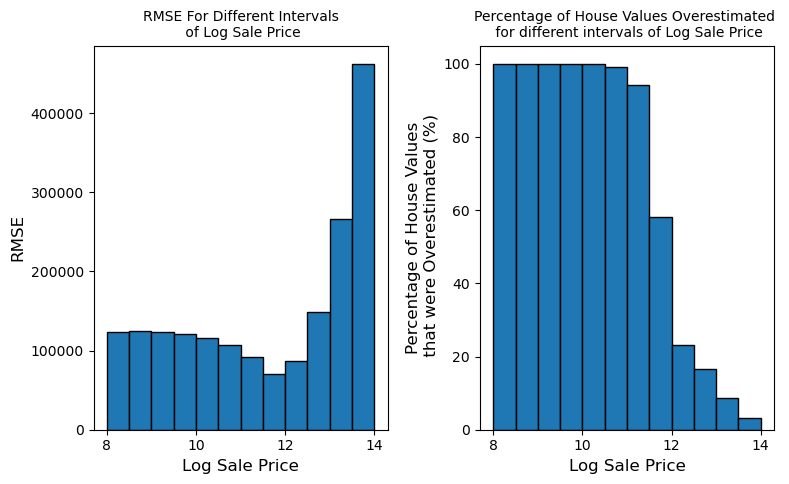

In [49]:
# RMSE plot
plt.figure(figsize = (8,5))
plt.subplot(1, 2, 1) 
rmses = []
for i in np.arange(8, 14, 0.5):
    rmses.append(rmse_interval(preds_df, i, i + 0.5))
plt.bar(x = np.arange(8.25, 14.25, 0.5), height = rmses, edgecolor = 'black', width = 0.5)
plt.title('RMSE For Different Intervals\n of Log Sale Price', fontsize = 10)
plt.xlabel('Log Sale Price')
plt.yticks(fontsize = 10)
plt.xticks(fontsize = 10)
plt.ylabel('RMSE')

# Overestimation plot  
plt.subplot(1, 2, 2)
props = []
for i in np.arange(8, 14, 0.5):
    props.append(prop_overest_interval(preds_df, i, i + 0.5) * 100) 
plt.bar(x = np.arange(8.25, 14.25, 0.5), height = props, edgecolor = 'black', width = 0.5)
plt.title('Percentage of House Values Overestimated \n for different intervals of Log Sale Price', fontsize = 10)
plt.xlabel('Log Sale Price')
plt.yticks(fontsize = 10)
plt.xticks(fontsize = 10)
plt.ylabel('Percentage of House Values\n that were Overestimated (%)')

plt.tight_layout()
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<br>

<hr style="border: 1px solid #fdb515;" />

## Section 7: Evaluating the Model in Context

<br>

---
## Part 7-1

When evaluating my model, I used RMSE. In the context of estimating the value of houses, what does the residual mean for an individual homeowner? How does a positive or negative residual affect them in terms of property taxes? Discuss the cases where the residual is positive and negative separately.

A positive residual means the model underestimates the property's value, resulting in lower property taxes for the homeowner. On the other hand, a negative residual means the model overestimates the property's value, leading to higher property taxes for the homeowner.

<!-- END QUESTION -->

In the case of the Cook County Assessor’s Office, Chief Data Officer Rob Ross states that fair property tax rates are contingent on whether property values are assessed accurately —— that they’re valued at what they’re worth, relative to properties with similar characteristics. This implies that having a more accurate model results in fairer assessments. The goal of the property assessment process for the CCAO, then, is to be as accurate as possible. 

When the use of algorithms and statistical modeling has real-world consequences, we often refer to the idea of fairness as a measurement of how socially responsible our work is. Fairness is incredibly multifaceted: Is a fair model one that minimizes loss - one that generates accurate results? Is it one that utilizes "unbiased" data? Or is fairness a broader goal that takes historical contexts into account?

These approaches to fairness are not mutually exclusive. If we look beyond error functions and technical measures of accuracy, we'd not only consider _individual_ cases of fairness but also what fairness —— and justice —— means to marginalized communities on a broader scale. We'd ask: What does it mean when homes in predominantly Black and Hispanic communities in Cook County are consistently overvalued, resulting in proportionally higher property taxes? When the white neighborhoods in Cook County are consistently undervalued, resulting in proportionally lower property taxes? 

Having "accurate" predictions doesn't necessarily address larger historical trends and inequities, and fairness in property assessments in taxes works beyond the CCAO's valuation model. Disassociating accurate predictions from a fair system is vital to approaching justice at multiple levels. Take Evanston, IL —— a suburb in Cook County —— as an example of housing equity beyond just improving a property valuation model: their City Council members [recently approved reparations for African American residents](https://www.usnews.com/news/health-news/articles/2021-03-23/chicago-suburb-approves-government-reparations-for-black-residents).


<!-- BEGIN QUESTION -->

<br>

---

## Part 7-2

What makes a model's predictions of property values for tax assessment purposes "fair"? 

A model's predictions of property values for tax assessment purposes are considered "fair" when they provide an accurate and consistent estimate across all properties. The purpose was to treat any specific group of homeowners fairly without favoring or disadvantaging their traits on their property’s value. Fairness, in this case, goes beyond just having a low RMSE. It requires that the model's residuals are not systematically biased toward either overestimating or underestimating values for certain price ranges or neighborhoods. A model with a low RMSE can be inaccurate if it consistently overestimates or underestimates the values for a specific subset of properties, which could lead to inequitable taxation. While accuracy is important, fairness also encompasses how evenly the model performs across different types of properties—ensuring that homeowners with lower or higher value properties are not disproportionately affected by the model's mistakes.